In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    RocCurveDisplay,
)

sns.set(style="whitegrid", context="notebook") 

### Load dataset and initial inspection  

We start by loading the immunotherapy classification dataset and inspecting its basic structure:  
- first rows  
- data types  
- summary statistics for numeric variables  

In [4]:
df = pd.read_csv("../data/immunotherapy_classification.csv")

print("First rows:")
display(df.head())

print("\nInfo:")
print(df.info())

print("\nNumeric summary:")
display(df.describe())


First rows:


,Patient_ID,Age,Gender,ECOG_Score,PD_L1_Expression,TMB_Score,History_Autoimmune,Baseline_Troponin,Severe_Adverse_Event
0,PT-2180,64,Male,2,4.6,3.0,Yes,0.403,1
1,PT-1741,55,Female,0,29.8,5.0,No,0.092,0
2,PT-1550,90,Female,1,92.7,21.0,Yes,NaN,0
3,PT-2008,40,Female,2,22.1,3.0,Yes,0.166,0
4,PT-1750,75,Male,1,15.8,4.0,No,0.055,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Patient_ID            1200 non-null   object 
 1   Age                   1200 non-null   int64  
 2   Gender                1200 non-null   object 
 3   ECOG_Score            1200 non-null   int64  
 4   PD_L1_Expression      1200 non-null   float64
 5   TMB_Score             1140 non-null   float64
 6   History_Autoimmune    1200 non-null   object 
 7   Baseline_Troponin     1164 non-null   float64
 8   Severe_Adverse_Event  1200 non-null   int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 84.5+ KB
None

Numeric summary:


,Age,ECOG_Score,PD_L1_Expression,TMB_Score,Baseline_Troponin,Severe_Adverse_Event
count,1200.000000,1200.000000,1200.000000,1140.000000,1164.000000,1200.000000
mean,59.938333,0.825000,42.529833,14.468421,0.261607,0.411667
std,11.741355,0.744874,30.874305,11.675292,0.267044,0.492341
min,30.000000,0.000000,0.000000,0.000000,0.027000,0.000000
25%,52.000000,0.000000,14.775000,4.000000,0.082000,0.000000
50%,60.000000,1.000000,35.050000,10.000000,0.145000,0.000000
75%,68.000000,1.000000,69.625000,24.000000,0.354500,1.000000
max,90.000000,2.000000,100.000000,53.000000,1.817000,1.000000


### Target check and ID cleanup  

Validate the target column, detect/remove ID-like fields, and review the remaining columns before moving on.

ID-like columns detected: ['Patient_ID']

Columns after dropping ID-like variables:
['Age', 'Gender', 'ECOG_Score', 'PD_L1_Expression', 'TMB_Score', 'History_Autoimmune', 'Baseline_Troponin', 'Severe_Adverse_Event']

Target distribution (counts):


Severe_Adverse_Event
0    706
1    494
Name: count, dtype: int64


Target distribution (proportions):


Severe_Adverse_Event
0    0.588333
1    0.411667
Name: proportion, dtype: float64

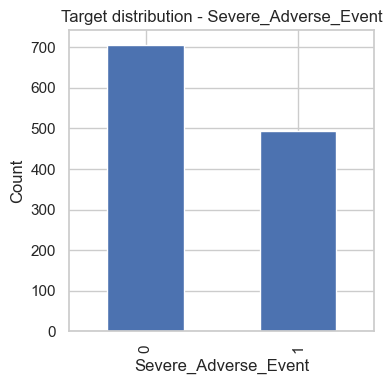

In [ ]:
target_col = "Severe_Adverse_Event"

if target_col not in df.columns:
    raise ValueError(f"Target column {target_col} not found. Available columns: {list(df.columns)}")

id_like_cols = [] # Detect ID-like columns automatically
for col in df.columns:
    lower_name = col.lower()
    if "id" in lower_name:
        id_like_cols.append(col)
    if col.startswith("Unnamed"):
        id_like_cols.append(col)

id_like_cols = sorted(list(set(id_like_cols)))
print("ID-like columns detected:", id_like_cols)

df = df.drop(columns=id_like_cols, errors="ignore")
print("\nColumns after dropping ID-like variables:")
print(list(df.columns))

print("\nTarget distribution (counts):") # Target distribution
display(df[target_col].value_counts())
print("\nTarget distribution (proportions):")
display(df[target_col].value_counts(normalize=True))

plt.figure(figsize=(4, 4))
df[target_col].value_counts().plot(kind="bar")
plt.title("Target distribution - Severe_Adverse_Event")
plt.xlabel("Severe_Adverse_Event")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### Exploratory Data Analysis (EDA)

In this section we look at:  
- missing values  
- distributions of main clinical variables  
- simple correlations between numeric features  

This helps understand the data quality and potential predictive signals.

In [6]:
print("Missing values per column:")
display(df.isna().sum())

Missing values per column:


Age                      0
Gender                   0
ECOG_Score               0
PD_L1_Expression         0
TMB_Score               60
History_Autoimmune       0
Baseline_Troponin       36
Severe_Adverse_Event     0
dtype: int64

<Figure size 1200x600 with 0 Axes>

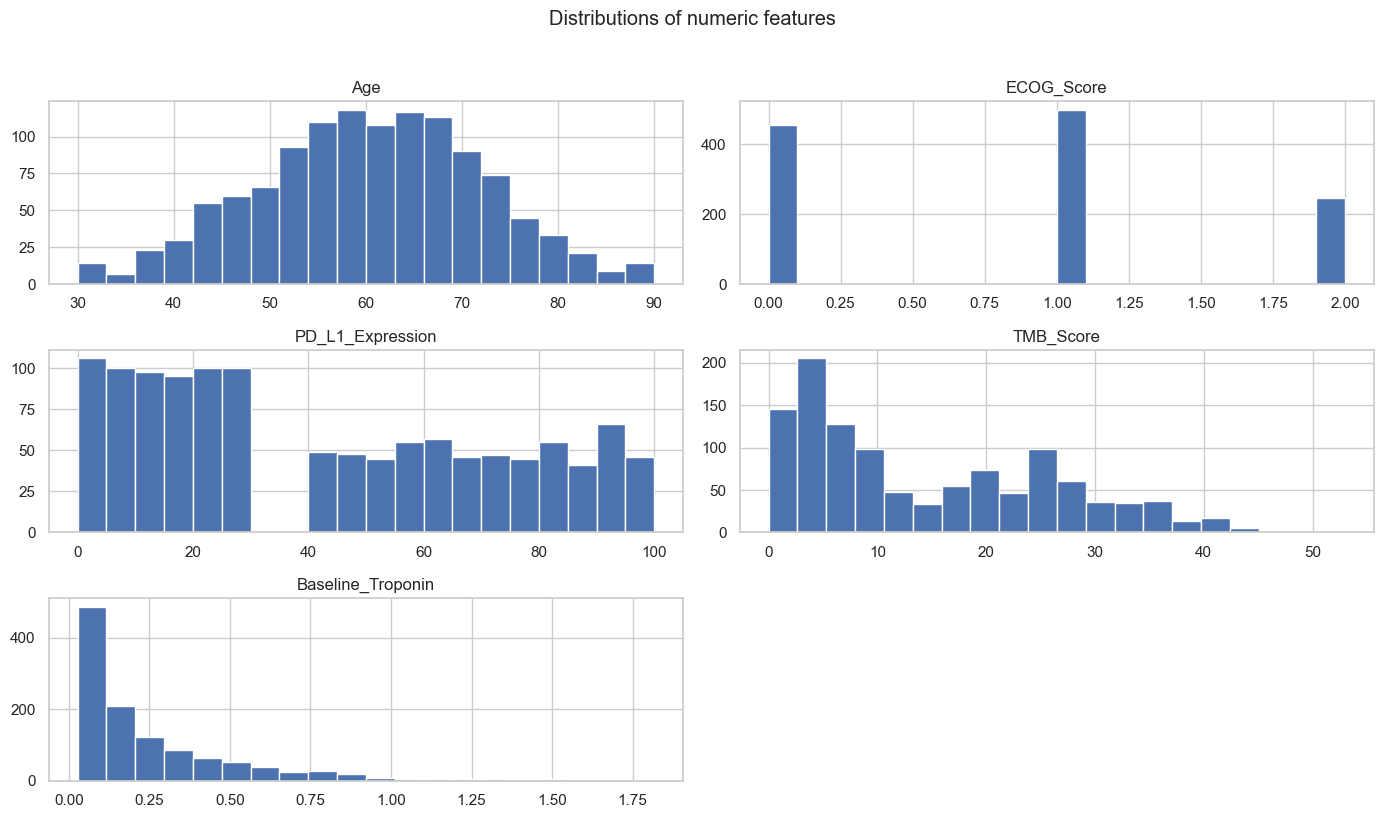

In [7]:
numeric_cols_all = df.select_dtypes(include=["number"]).columns.tolist()

# Exclude the target for numeric EDA
numeric_features = [c for c in numeric_cols_all if c != target_col]

plt.figure(figsize=(12, 6))
df[numeric_features].hist(bins=20, figsize=(14, 8))
plt.suptitle("Distributions of numeric features", y=1.02)
plt.tight_layout()
plt.show()

In [8]:
y = df[target_col]
X = df.drop(columns=[target_col])

numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['Age', 'ECOG_Score', 'PD_L1_Expression', 'TMB_Score', 'Baseline_Troponin']
Categorical columns: ['Gender', 'History_Autoimmune']


In [9]:
X_imputed = X.copy()

if numeric_cols:
    num_imputer = SimpleImputer(strategy="median")
    X_imputed[numeric_cols] = num_imputer.fit_transform(X_imputed[numeric_cols])

if categorical_cols:
    cat_imputer = SimpleImputer(strategy="most_frequent")
    X_imputed[categorical_cols] = cat_imputer.fit_transform(X_imputed[categorical_cols])

print("Missing values after imputation:")
display(X_imputed.isna().sum())


Missing values after imputation:


Age                   0
Gender                0
ECOG_Score            0
PD_L1_Expression      0
TMB_Score             0
History_Autoimmune    0
Baseline_Troponin     0
dtype: int64

In [ ]:
# One-hot encode categorical variables
X_processed = pd.get_dummies(X_imputed, columns=categorical_cols, drop_first=True)

print("Shape after one-hot encoding:", X_processed.shape)
print("Example of columns:", list(X_processed.columns)[:20])

# Remove near-constant features
low_variance_cols = [col for col in X_processed.columns if X_processed[col].nunique() <= 1]
print("Low-variance columns to drop:", low_variance_cols)

X_processed = X_processed.drop(columns=low_variance_cols)
print("Shape after dropping low-variance features:", X_processed.shape)


Shape after one-hot encoding: (1200, 7)
Example of columns: ['Age', 'ECOG_Score', 'PD_L1_Expression', 'TMB_Score', 'Baseline_Troponin', 'Gender_Male', 'History_Autoimmune_Yes']
Low-variance columns to drop: []
Shape after dropping low-variance features: (1200, 7)


### Train–test split  

We keep a held-out test set to evaluate generalisation performance.  
We use stratified sampling so that the class proportions are similar in train and test.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)


X_train: (960, 7)
X_test : (240, 7)
y_train: (960,)
y_test : (240,)


### Model 1 – Logistic Regression  

Logistic Regression is used as a baseline:  
- linear decision boundary  
- probabilistic output  
- coefficients are interpretable  

We scale the features before fitting the model.

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred_log = log_reg.predict(X_test_scaled)
y_proba_log = log_reg.predict_proba(X_test_scaled)[:, 1]

print("=== Logistic Regression performance on test set ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("ROC AUC:", roc_auc_score(y_test, y_proba_log))
print("\nClassification report:")
print(classification_report(y_test, y_pred_log))


=== Logistic Regression performance on test set ===
Accuracy: 0.8583333333333333
ROC AUC: 0.9133175728920409

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       141
           1       0.82      0.84      0.83        99

    accuracy                           0.86       240
   macro avg       0.85      0.86      0.85       240
weighted avg       0.86      0.86      0.86       240



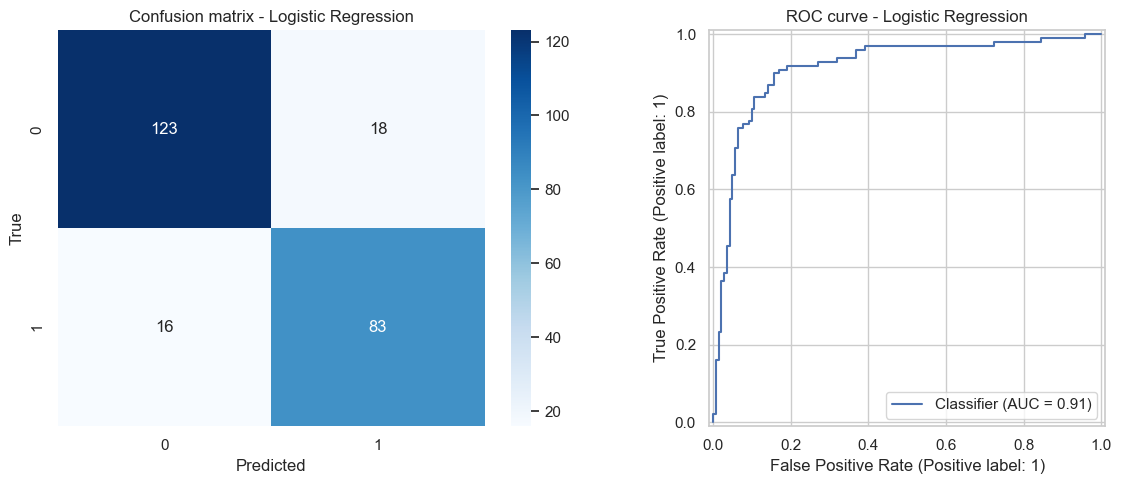

In [21]:
cm_log = confusion_matrix(y_test, y_pred_log)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title("Confusion matrix - Logistic Regression")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")

RocCurveDisplay.from_predictions(y_test, y_proba_log, ax=ax[1])
ax[1].set_title("ROC curve - Logistic Regression")

plt.tight_layout()
plt.show()


### Model 2 – Random Forest Classifier  

Random Forest is a non linear ensemble method:  
- combination of many decision trees  
- handles feature interactions automatically  
- less sensitive to scaling and outliers  

We keep `class_weight="balanced"` to compensate for possible class imbalance.

In [14]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("=== Random Forest performance on test set ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))
print("\nClassification report:")
print(classification_report(y_test, y_pred_rf))


=== Random Forest performance on test set ===
Accuracy: 0.8458333333333333
ROC AUC: 0.9118848055018268

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       141
           1       0.81      0.82      0.81        99

    accuracy                           0.85       240
   macro avg       0.84      0.84      0.84       240
weighted avg       0.85      0.85      0.85       240



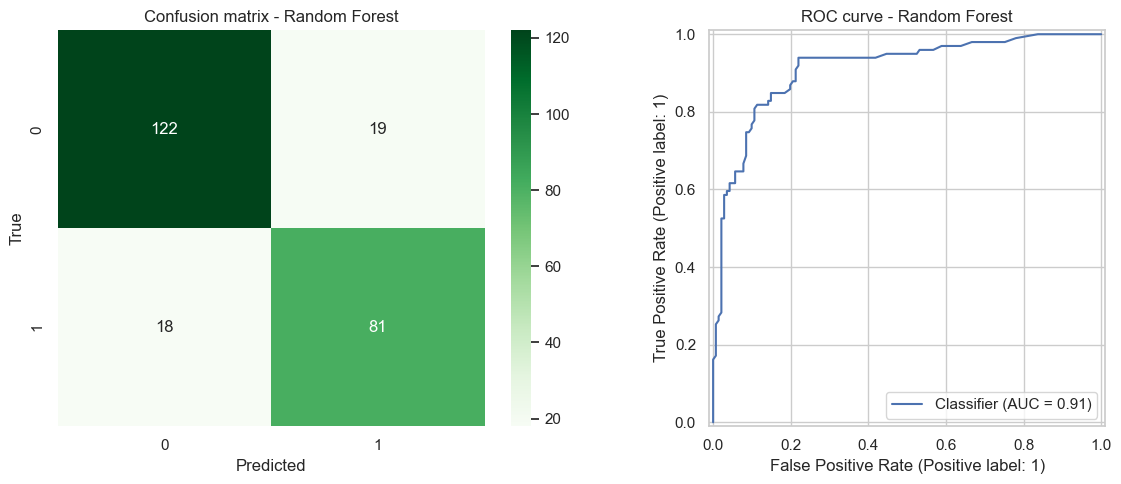

In [15]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", ax=ax[0])
ax[0].set_title("Confusion matrix - Random Forest")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")

RocCurveDisplay.from_predictions(y_test, y_proba_rf, ax=ax[1])
ax[1].set_title("ROC curve - Random Forest")

plt.tight_layout()
plt.show()


### Cross-validation and model comparison  

To obtain a more stable estimate of performance, we compute 5-fold cross-validated ROC AUC for both models on the full processed dataset.


In [16]:
# Cross validation for Logistic Regression (with scaling inside a simple wrapper)
from sklearn.pipeline import make_pipeline

log_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

scores_log = cross_val_score(
    log_pipeline,
    X_processed,
    y,
    cv=5,
    scoring="roc_auc",
)

scores_rf = cross_val_score(
    rf,
    X_processed,
    y,
    cv=5,
    scoring="roc_auc",
)

print("Logistic Regression ROC AUC (5-fold):")
print("Scores:", scores_log)
print("Mean:", scores_log.mean(), "Std:", scores_log.std())

print("\nRandom Forest ROC AUC (5-fold):")
print("Scores:", scores_rf)
print("Mean:", scores_rf.mean(), "Std:", scores_rf.std())


Logistic Regression ROC AUC (5-fold):
Scores: [0.90479261 0.87778494 0.86102156 0.89547962 0.92167289]
Mean: 0.8921503250156018 Std: 0.02106113793009672

Random Forest ROC AUC (5-fold):
Scores: [0.90450605 0.86367218 0.86374382 0.89354538 0.92152918]
Mean: 0.8893993230822719 Std: 0.022793951061875296


### Model comparison and choice

Using "5"-fold cross-validated ROC AUC on the full processed dataset, we obtain:

- **Logistic Regression**  
  - ROC AUC scores: 0.905, 0.878, 0.861, 0.895, 0.922  
  - Mean ROC AUC = **0.892**  
  - Standard deviation = **0.021**

- **Random Forest**  
  - ROC AUC scores: 0.905, 0.864, 0.864, 0.894, 0.922  
  - Mean ROC AUC = **0.889**  
  - Standard deviation = **0.023**

The two models achieve **very similar performance**, but Logistic Regression shows:

- a **slightly higher mean ROC AUC**,  
- a **slightly lower variance** across folds (more stable behaviour).

Given that Logistic Regression is also **simpler and more interpretable** (coefficients can be directly linked to clinical risk factors), it is reasonable to select **Logistic Regression as the primary model** for this dataset, while Random Forest is kept as a competitive non-linear benchmark.


### Interpretation  

We now inspect which features drive the model decisions.

- For Logistic Regression, we can interpret the sign and magnitude of coefficients (after scaling).  
- For Random Forest, we use feature importance scores.


,feature,coefficient
6,History_Autoimmune_Yes,1.560963
4,Baseline_Troponin,0.573211
5,Gender_Male,0.032418
1,ECOG_Score,0.002372
0,Age,-0.013556
3,TMB_Score,-0.072193
2,PD_L1_Expression,-0.083789


,feature,coefficient
6,History_Autoimmune_Yes,1.560963
4,Baseline_Troponin,0.573211
5,Gender_Male,0.032418
1,ECOG_Score,0.002372
0,Age,-0.013556
3,TMB_Score,-0.072193
2,PD_L1_Expression,-0.083789


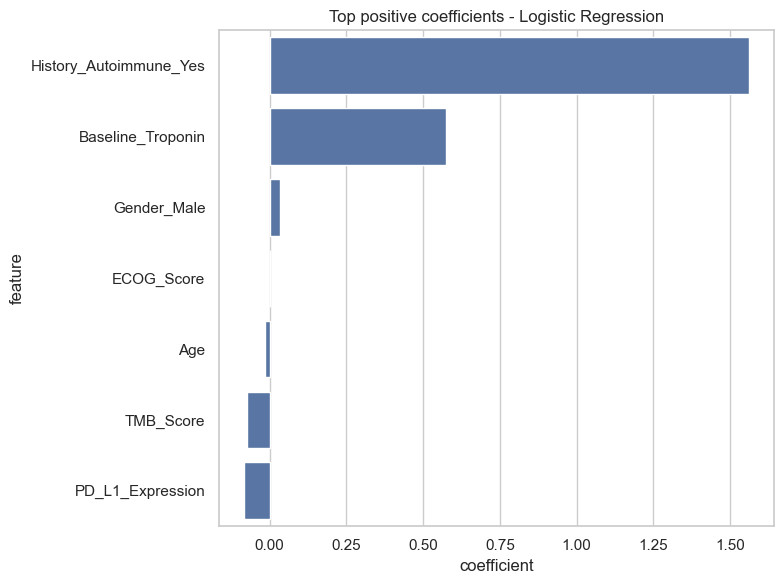

In [17]:
# Refit logistic regression on all data (scaled) to inspect coefficients
log_reg_full = LogisticRegression(max_iter=1000)
X_scaled_full = StandardScaler().fit_transform(X_processed)
log_reg_full.fit(X_scaled_full, y)

coef = log_reg_full.coef_[0]
feature_names = X_processed.columns

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef,
}).sort_values("coefficient", ascending=False)

display(coef_df.head(10))
display(coef_df.tail(10))

plt.figure(figsize=(8, 6))
top_k = 10
sns.barplot(
    data=coef_df.head(top_k),
    x="coefficient",
    y="feature",
)
plt.title("Top positive coefficients - Logistic Regression")
plt.tight_layout()
plt.show()

,feature,importance
0,Baseline_Troponin,0.314850
1,History_Autoimmune_Yes,0.311416
2,PD_L1_Expression,0.125962
3,Age,0.104765
4,TMB_Score,0.096502
5,ECOG_Score,0.029384
6,Gender_Male,0.017121


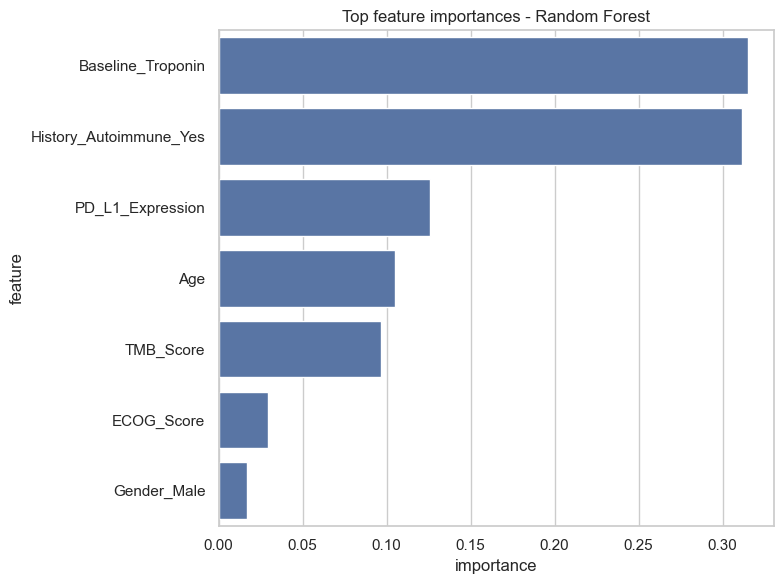

In [18]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
k = min(15, len(indices))
top_indices = indices[:k]

fi_df = pd.DataFrame({
    "feature": X_processed.columns[top_indices],
    "importance": importances[top_indices],
})

display(fi_df)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=fi_df,
    x="importance",
    y="feature",
    orient="h",
)
plt.title("Top feature importances - Random Forest")
plt.tight_layout()
plt.show()


Model Interpretation and Final Choice

Both models identify baseline troponin as a key predictor of severe adverse events. Logistic Regression assigns it a moderate positive coefficient, reflecting a linear increase in risk as troponin rises.

Random Forest, however, ranks troponin as the single most important feature. This difference arises because Random Forest captures non-linear threshold effects: even moderate elevations in troponin sharply increase toxicity risk, something a linear model cannot fully express.

Despite this, Logistic Regression performs slightly better overall in cross-validated ROC AUC (≈ 0.892 vs. 0.889) and shows lower variability across folds. It is also simpler, more interpretable, and easier to communicate in a clinical setting because coefficients directly indicate how each variable affects risk.

For these reasons, Logistic Regression is selected as the final model.
It provides strong predictive performance while remaining transparent and clinically interpretable—two essential criteria in a medical decision-making context.

### Challenges and Improvements

**Challenges:**
- Heterogeneous data: mix of continuous labs (troponin, TMB) and categorical clinical flags demands careful encoding and can dilute signals.
- Missing values: median/most-frequent imputation may bias rare but clinically important patterns and shift distributions.
- Class imbalance: severe adverse events likely under-represented, making accuracy misleading and calibration fragile.
- Outliers and thresholds: extreme biomarkers can distort linear boundaries; non-linear cutoffs may matter clinically.
- Interpretability: clinicians need clear links between features and risk; black-box models slow adoption.
- Pipeline fragility: schema changes or unseen categorical levels can break preprocessing if not encapsulated.

**Possible improvements:**
- Robust pipeline: `ColumnTransformer` + `Pipeline` to chain imputation, encoding, scaling, and avoid leakage.
- Better metrics and balancing: stratified splits, class weights, and AUC/PR/F1 focus instead of accuracy.
- Richer models: penalized logistic regression, gradient boosting, or calibrated random forests to capture interactions while regularizing.
- Outlier handling: winsorize or use robust models; inspect high-troponin/high-risk subgroups separately.
- Probability calibration and explainability: Platt/Isotonic calibration plus SHAP/feature importances for clinician-facing risk insights.
- Validation discipline: cross-validation with held-out test, learning curves, and drift checks to ensure generalization over time.